In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import seaborn as sns
import pymc as pm
import bambi as bmb
import arviz as az
from scipy import stats
from scipy.special import expit
import os
cwd = os.getcwd()
import warnings
warnings.filterwarnings('ignore')
import R2_Bayes as r2
import ame_Bayes as ame

In [2]:
DF= pd.read_csv(cwd[:-4]+'/Data/counties_data_2012_2022.csv', low_memory= False)

In [3]:
DF.columns[-100:-50]

Index(['LABOR, HIRED - NUMBER OF WORKERS',
       'PRODUCERS, BLACK OR AFRICAN AMERICAN - ACRES OPERATED',
       'PRODUCERS, BLACK OR AFRICAN AMERICAN - NUMBER OF PRODUCERS',
       'PRODUCERS, FEMALE - ACRES OPERATED',
       'PRODUCERS, FEMALE - NUMBER OF PRODUCERS',
       'PRODUCERS, HISPANIC - ACRES OPERATED',
       'PRODUCERS, HISPANIC - NUMBER OF PRODUCERS',
       'PRODUCERS, WHITE - ACRES OPERATED',
       'RENT, CASH, LAND & BUILDINGS - EXPENSE, MEASURED IN $', 'year',
       'PRACTICES, LAND USE, CROPLAND, COVER CROP PLANTED, (EXCL CRP) - ACRES',
       'PRACTICES, LAND USE, CROPLAND, COVER CROP PLANTED, (EXCL CRP) - NUMBER OF OPERATIONS',
       'PRODUCERS, AGE 35 TO 44 - NUMBER OF PRODUCERS',
       'PRODUCERS, AGE 45 TO 54 - NUMBER OF PRODUCERS',
       'PRODUCERS, AGE 55 TO 64 - NUMBER OF PRODUCERS',
       'PRODUCERS, AGE 65 TO 74 - NUMBER OF PRODUCERS',
       'PRODUCERS, AGE GE 75 - NUMBER OF PRODUCERS',
       'PRODUCERS, AGE LT 25 - NUMBER OF PRODUCERS', 'state_pr

In [4]:
DF= DF[DF.State!= 'Hawaii']#[['county_fips','state_fips','State','state_abb', 'Region_fips']]
DF['Region_name']= DF['Region']
DF['Region']= DF['Region_name']
DF= pd.get_dummies(DF, columns=['Region'])
DF['year_2017'] = np.where(DF['year']==2017, 1, 0)
DF['year_2022'] = np.where(DF['year']==2022, 1, 0)

In [5]:
DF.groupby('year')['cc_acres_tot'].sum()

year
2012    10204192.0
2017    15295556.0
2022    17898693.0
Name: cc_acres_tot, dtype: float64

In [5]:
DF= pd.get_dummies(DF, columns=['state_abb'])

In [213]:
DF.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
DF.dropna(axis=0, how='any',subset=['covercrop_acres',
            'women_acres', #demographics
            'labor_expense','org_ope', #farm management
            'pasture_cropland', 'irrigated_harvcrop_ope','entropy', 
            'cons_prog_income','noncons_prog_income','state_prog_ope',
            'insurance_acres','subsidy_ratio',
            'individual', 'human', 'regulate', #opinion
            'tavg_std', 'edd_mean', #weather
            'pcp_mm_std', 'pcpdays_mean',
            'tavg_z','pcp_mm_z'], inplace=True)

In [7]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['region']= dfy.variables.str[-2:-1]
    
    return dfy

In [8]:
# Keep counties with at least 2 observations
DF.sort_values(by= ['county_fips','year'], inplace=True)
DF['cons']=1
DF['times']= DF.groupby(['county_fips'])['cons'].transform(sum)

## Cover crop variation over time

In [ ]:
states= ['state_abb_AL', 'state_abb_AR', 'state_abb_AZ',
       'state_abb_CA', 'state_abb_CO', 'state_abb_CT', 'state_abb_DE',
       'state_abb_FL', 'state_abb_GA', 'state_abb_IA', 'state_abb_ID',
       'state_abb_IL', 'state_abb_IN', 'state_abb_KS', 'state_abb_KY',
       'state_abb_LA', 'state_abb_MA', 'state_abb_MD', 'state_abb_ME',
       'state_abb_MI', 'state_abb_MN', 'state_abb_MO', 'state_abb_MS',
       'state_abb_MT', 'state_abb_NC', 'state_abb_ND', 'state_abb_NE',
       'state_abb_NH', 'state_abb_NJ', 'state_abb_NM', 'state_abb_NV',
       'state_abb_NY', 'state_abb_OH', 'state_abb_OK', 'state_abb_OR',
       'state_abb_PA', 'state_abb_RI', 'state_abb_SC', 'state_abb_SD',
       'state_abb_TN', 'state_abb_TX', 'state_abb_UT', 'state_abb_VA',
       'state_abb_VT', 'state_abb_WA', 'state_abb_WI', 'state_abb_WV',
       'state_abb_WY']

## Disadoption prediction without county fixed effects

In [9]:
varsd= ['cc_acres_tot','covercrop_acres','covercrop_ope','women_acres',  #demographics
            'labor_expense','org_ope', #farm management
            'pasture_cropland', 'irrigated_harvcrop_ope','entropy', 
            'cons_prog_income','noncons_prog_income','state_prog_ope','insurance_acres',
            'subsidy_ratio',
            'individual', 'human', 'regulate', #opinion
            'tavg_std', 'edd_mean', #weather
            'pcp_mm_std', 'pcpdays_mean',
            'tavg_z','pcp_mm_z']


DF4= DF[['Region_fips','times','county_fips', 'state_fips', 'year', 'year_2022']+ varsd ]
DF4= DF4[DF4['times']>1]
DF4.sort_values(by= ['county_fips', 'year'], ascending= True, inplace= True)

DF4['cc_lag']= DF4.groupby(['county_fips'])['covercrop_acres'].shift()
DF4['covercrop_var']= DF4['covercrop_acres'] - DF4['cc_lag']
    

DF4.loc[DF4['covercrop_var']< 0, 'disadoption']= 1
DF4.loc[DF4['covercrop_var']>0, 'disadoption']= 0

DF4.replace([np.inf, -np.inf], np.nan, inplace=True)

In [82]:
# Disadoption in terms of operations
DF4['ope_lag']= DF4.groupby(['county_fips'])['covercrop_ope'].shift()
DF4['ope_var']= DF4['covercrop_ope'] - DF4['ope_lag']
    

DF4.loc[DF4['ope_var']< 0, 'disadoption_ope']= 1
DF4.loc[DF4['ope_var']>0, 'disadoption_ope']= 0

In [175]:
DF4[['year','covercrop_acres','cc_lag', 'covercrop_var','disadoption']]

,year,covercrop_acres,cc_lag,covercrop_var,disadoption
0,2012,0.028964,NaN,NaN,NaN
67,2017,0.045026,0.028964,0.016062,0.0
134,2022,0.103241,0.045026,0.058216,0.0
1,2012,0.175102,NaN,NaN,NaN
68,2017,0.355720,0.175102,0.180618,0.0
...,...,...,...,...,...
9169,2012,0.019904,NaN,NaN,NaN
9192,2017,0.048767,0.019904,0.028863,0.0
9215,2022,0.074670,0.048767,0.025903,0.0
9170,2012,0.046524,NaN,NaN,NaN


In [10]:
# Standarizing variables (without county fixed effects)
varsd= ['women_acres',  #demographics
            'labor_expense','org_ope', #farm management
            'pasture_cropland', 'irrigated_harvcrop_ope','entropy', 
            'cons_prog_income','noncons_prog_income','state_prog_ope','insurance_acres',
            'subsidy_ratio',
            'individual', 'human', 'regulate', #opinion
            'tavg_std', 'edd_mean', #weather
            'pcp_mm_std', 'pcpdays_mean',
            'tavg_z','pcp_mm_z']
DF5= DF4[['Region_fips','times','county_fips', 'state_fips', 'year', 'year_2022', 'disadoption', 'covercrop_acres']+
         varsd]
DF5= DF5[DF5['times']>1]

for x in varsd:
    DF5[x].replace(0, 0.00001, inplace=True)
    DF5[x+'_diff']= ((DF5[x]- DF5[x].mean()))/DF5[x].std() #standardize with population of counties
DF5.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
DF5= DF5[DF5['year']!= 2012]
DF5

,Region_fips,times,county_fips,state_fips,year,year_2022,disadoption,covercrop_acres,women_acres,labor_expense,...,subsidy_ratio_diff,individual_diff,human_diff,regulate_diff,tavg_std_diff,edd_mean_diff,pcp_mm_std_diff,pcpdays_mean_diff,tavg_z_diff,pcp_mm_z_diff
67,5,3,1001,1,2017,0,0.0,0.045026,0.399440,0.120520,...,-0.085503,-0.476982,-0.132732,0.061122,-0.195758,1.299529,-0.061886,1.267696,0.095826,0.262242
134,5,3,1001,1,2022,1,0.0,0.103241,0.441197,0.185657,...,-0.406193,0.269858,-0.655830,-1.096977,-0.259750,1.397144,0.637599,1.485483,0.949050,1.163526
68,5,3,1003,1,2017,0,0.0,0.355720,0.276546,0.176239,...,-0.645145,-0.657222,-0.293685,-0.103381,-0.493919,1.366085,0.766398,2.182401,-0.038989,0.276886
135,5,3,1003,1,2022,1,1.0,0.151732,0.318562,0.224896,...,-0.707018,0.097012,-0.897260,-1.404049,-0.828973,1.468137,0.443478,1.790385,0.416041,-0.131615
69,5,3,1005,1,2017,0,0.0,0.119156,0.407357,0.065409,...,0.621601,1.247774,0.817659,0.817834,-0.255128,1.370522,1.096941,1.529040,-0.186960,0.754242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9187,3,3,56033,56,2017,0,1.0,0.007976,0.478356,0.141617,...,-0.015494,-0.367914,-0.138480,-0.120928,-0.644357,-0.967802,-1.653424,-1.650650,-0.517353,0.149127
9210,3,3,56033,56,2022,1,0.0,0.025162,0.405252,0.142694,...,0.030421,0.198686,-1.100368,-1.805435,-0.313760,-0.932306,-1.049135,-1.694208,-0.679353,-1.138140
9192,3,3,56043,56,2017,0,0.0,0.048767,0.397579,0.149041,...,-1.623305,-0.381779,0.145105,-0.239370,-0.918982,-0.479727,-1.785830,-1.781323,-0.392044,0.892676
9215,3,3,56043,56,2022,1,0.0,0.074670,0.458842,0.136295,...,0.424503,0.070207,-1.081207,-2.066446,-1.109965,-0.399860,-1.141140,-1.781323,-0.727891,-0.747920


### Model without county fixed effects

In [220]:
sigma1= 1 #bmb.Prior('HalfCauchy', beta= 1)

priorsb={'Intercept': bmb.Prior("Normal", mu= 0, sigma= 1),    
    'women_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'individual_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'year_2022': bmb.Prior("Laplace", mu=0, b=sigma1)
        }


In [221]:
modela1 = bmb.Model("disadoption ~ 1 +\
            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+\
(insurance_acres_diff)+(subsidy_ratio_diff)+\
(edd_mean_diff)+(pcpdays_mean_diff)+(tavg_std_diff)+(pcp_mm_std_diff)+(tavg_z_diff) +(pcp_mm_z_diff)+\
(women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+\
(pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+\
(individual_diff)+(human_diff)+(regulate_diff)+(year_2022)",
            DF5, priors= priorsb, family="bernoulli", dropna=True)
modela1 #

Automatically removing 172/3955 rows from the dataset.


Formula: disadoption ~ 1 +            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+(insurance_acres_diff)+(subsidy_ratio_diff)+(edd_mean_diff)+(pcpdays_mean_diff)+(tavg_std_diff)+(pcp_mm_std_diff)+(tavg_z_diff) +(pcp_mm_z_diff)+(women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+(pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+(individual_diff)+(human_diff)+(regulate_diff)+(year_2022)
Family name: Bernoulli
Link: logit
Observations: 3783
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 1)
    cons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    noncons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    state_prog_ope_diff ~ Laplace(mu: 0, b: 1)
    insurance_acres_diff ~ Laplace(mu: 0, b: 1)
    subsidy_ratio_diff ~ Laplace(mu: 0, b: 1)
    edd_mean_diff ~ Laplace(mu: 0, b: 1)
    pcpdays_mean_diff ~ Laplace(mu: 0, b: 1)
    tavg_std_diff ~ Laplace(mu: 0, b: 1)
    pcp_mm_std_diff ~ Laplace(mu: 0, b: 1)
    tavg_z_diff ~ Laplac

In [222]:
tracea1 = modela1.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Modeling the probability that disadoption==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, year_2022, regulate_diff, human_diff, individual_diff, entropy_diff, irrigated_harvcrop_ope_diff, pasture_cropland_diff, org_ope_diff, labor_expense_diff, women_acres_diff, pcp_mm_z_diff, tavg_z_diff, pcp_mm_std_diff, tavg_std_diff, pcpdays_mean_diff, edd_mean_diff, subsidy_ratio_diff, insurance_acres_diff, state_prog_ope_diff, noncons_prog_income_diff, cons_prog_income_diff]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 186 seconds.


In [223]:
az.summary(tracea1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.974,0.081,-1.124,-0.828,0.001,0.001,4593.0,2810.0,1.0
cons_prog_income_diff,-0.083,0.041,-0.163,-0.009,0.001,0.000,5032.0,3236.0,1.0
noncons_prog_income_diff,-0.006,0.034,-0.073,0.055,0.000,0.001,6063.0,3054.0,1.0
state_prog_ope_diff,-0.012,0.035,-0.078,0.051,0.000,0.001,5461.0,2579.0,1.0
insurance_acres_diff,-0.202,0.054,-0.303,-0.105,0.001,0.001,4307.0,3341.0,1.0
subsidy_ratio_diff,0.068,0.046,-0.015,0.156,0.001,0.000,4996.0,3211.0,1.0
edd_mean_diff,0.072,0.062,-0.039,0.191,0.001,0.001,3858.0,3224.0,1.0
pcpdays_mean_diff,0.007,0.059,-0.105,0.114,0.001,0.001,3844.0,2771.0,1.0
tavg_std_diff,-0.184,0.063,-0.308,-0.077,0.001,0.001,4970.0,3172.0,1.0
pcp_mm_std_diff,0.025,0.045,-0.055,0.115,0.001,0.001,4446.0,3192.0,1.0


In [178]:
#DF5['I(cc_lag_diff ** 2)']= DF5a['cc_lag_diff']**2
DF5['cons']=1 
varpost= ['Intercept',#'cc_lag_diff','I(cc_lag_diff ** 2)',
            'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff',
            'edd_mean_diff', 'pcpdays_mean_diff', #weather
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff','pcp_mm_z_diff',
         'women_acres_diff',  #demographics
           'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff', 
          'individual_diff', 'human_diff', 'regulate_diff', 'year_2022']

varsdf= ['cons', #'cc_lag_diff','I(cc_lag_diff ** 2)',
        'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff',
         'insurance_acres_diff', 'subsidy_ratio_diff',
            'edd_mean_diff', 'pcpdays_mean_diff', #weather
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff','pcp_mm_z_diff',
         'women_acres_diff',  #demographics
           'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff', 
          'individual_diff', 'human_diff', 'regulate_diff', 'year_2022']

DF5_clean= DF5
DF5_clean.dropna(axis=0, how='any',subset=['disadoption',#'cc_lag_diff', 'I(cc_lag_diff ** 2)',
            'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff',
            'edd_mean_diff', 'pcpdays_mean_diff', #weather
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff','pcp_mm_z_diff',
         'women_acres_diff',  #demographics
           'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff', 
          'individual_diff', 'human_diff', 'regulate_diff', 'year_2022'], inplace=True)


In [179]:
print(az.hdi(tracea1,var_names=varpost[:12], hdi_prob = 0.99).values())
print(az.hdi(tracea1,var_names=varpost[12:], hdi_prob = 0.99).values())
#print(az.hdi(tracea,var_names=varpost[20:], hdi_prob = 0.99).values())

ValuesView(<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept                 (hdi) float64 -1.201 -0.7649
    cons_prog_income_diff     (hdi) float64 -0.1911 0.01594
    noncons_prog_income_diff  (hdi) float64 -0.08941 0.08185
    state_prog_ope_diff       (hdi) float64 -0.1109 0.07282
    insurance_acres_diff      (hdi) float64 -0.3292 -0.05404
    subsidy_ratio_diff        (hdi) float64 -0.04609 0.1895
    edd_mean_diff             (hdi) float64 -0.08844 0.2145
    pcpdays_mean_diff         (hdi) float64 -0.1438 0.1555
    tavg_std_diff             (hdi) float64 -0.365 -0.03089
    pcp_mm_std_diff           (hdi) float64 -0.09297 0.1497
    tavg_z_diff               (hdi) float64 -0.119 0.1526
    pcp_mm_z_diff             (hdi) float64 0.01718 0.2571)
ValuesView(<xarray.Dataset>
Dimensions:                      (hdi: 2)
Coordinates:
  * hdi                          (hdi) <U6 'lo

In [180]:
print(az.hdi(tracea1,var_names=varpost[:12], hdi_prob = 0.90).values())
print(az.hdi(tracea1,var_names=varpost[12:], hdi_prob = 0.90).values())

ValuesView(<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept                 (hdi) float64 -1.096 -0.8261
    cons_prog_income_diff     (hdi) float64 -0.1528 -0.01904
    noncons_prog_income_diff  (hdi) float64 -0.0571 0.0532
    state_prog_ope_diff       (hdi) float64 -0.07871 0.03889
    insurance_acres_diff      (hdi) float64 -0.2818 -0.1022
    subsidy_ratio_diff        (hdi) float64 -0.01254 0.1374
    edd_mean_diff             (hdi) float64 -0.0315 0.1665
    pcpdays_mean_diff         (hdi) float64 -0.08718 0.1052
    tavg_std_diff             (hdi) float64 -0.2864 -0.07477
    pcp_mm_std_diff           (hdi) float64 -0.04866 0.1025
    tavg_z_diff               (hdi) float64 -0.07745 0.09953
    pcp_mm_z_diff             (hdi) float64 0.06668 0.2169)
ValuesView(<xarray.Dataset>
Dimensions:                      (hdi: 2)
Coordinates:
  * hdi                          (hdi) <U6 

In [255]:
az.loo(tracea1)

Computed from 4000 posterior samples and 3768 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2054.21    30.21
p_loo       32.22        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3768  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [181]:
h= 0.0001
dfame= ame.ame_pooled(DF5_clean, tracea1, varsdf, varpost, h)

In [182]:
dfame

,AME,std,CI25,CI97
cons,0.274291,1.110370e-16,0.274291,0.274291
cons_prog_income_diff,-0.017147,3.582391e-03,-0.021000,-0.009042
noncons_prog_income_diff,-0.000832,1.737538e-04,-0.001019,-0.000439
state_prog_ope_diff,-0.003204,6.694792e-04,-0.003924,-0.001690
insurance_acres_diff,-0.040835,8.531404e-03,-0.050010,-0.021533
subsidy_ratio_diff,0.013604,2.842236e-03,0.007174,0.016661
edd_mean_diff,0.013310,2.780763e-03,0.007019,0.016301
pcpdays_mean_diff,0.002263,4.728597e-04,0.001193,0.002772
tavg_std_diff,-0.037920,7.922342e-03,-0.046440,-0.019996
pcp_mm_std_diff,0.005727,1.196549e-03,0.003020,0.007014


In [183]:
def prediction_pooled(DFmain, trace, varsdf, varspost, betavars, mainvar, labelresult): 
    for x,i in zip(varsdf, list(range(len(varpost)))):
        DFmain['beta_'+x]= DFmain[x]* az.summary(tracea1).iloc[i,0]

    DFmain['likelihood']= 1/(1+ np.exp(-DFmain[A].sum(axis=1)))
    DFmain['y_hat'] = np.where(DFmain['likelihood']>0.5, 1, 0)

    condlist= [(DFmain['y_hat']==1) & (DFmain[mainvar]==1), 
               ((DFmain['y_hat']==0) & (DFmain[mainvar]==1)), 
              ((DFmain['y_hat']==1) & (DFmain[mainvar]==0)), 
               ((DFmain['y_hat']==0) & (DFmain[mainvar]==0))]
    choicelist=[1,2,3,4]
    DFmain[labelresult] = np.select(condlist, choicelist, np.nan)

In [184]:
DF5['cons']=1

In [185]:
varpost= ['Intercept',#'cc_lag_diff','I(cc_lag_diff ** 2)',
            'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff',
            'edd_mean_diff', 'pcpdays_mean_diff', #weather
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff','pcp_mm_z_diff',
         'women_acres_diff',  #demographics
           'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff', 
          'individual_diff', 'human_diff', 'regulate_diff', 'year_2022']

varsdf= ['cons', #'cc_lag_diff','I(cc_lag_diff ** 2)',
        'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff',
         'insurance_acres_diff', 'subsidy_ratio_diff',
            'edd_mean_diff', 'pcpdays_mean_diff', #weather
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff','pcp_mm_z_diff',
         'women_acres_diff',  #demographics
           'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff', 
          'individual_diff', 'human_diff', 'regulate_diff', 'year_2022']
A= ['beta_cons', #'beta_cc_lag_diff', 'beta_I(cc_lag_diff ** 2)',
           'beta_cons_prog_income_diff', 'beta_noncons_prog_income_diff',
           'beta_state_prog_ope_diff', 'beta_insurance_acres_diff',
           'beta_subsidy_ratio_diff',
           'beta_edd_mean_diff', 'beta_pcpdays_mean_diff',
           'beta_tavg_std_diff', 'beta_pcp_mm_std_diff',
           'beta_tavg_z_diff', 'beta_pcp_mm_z_diff',
           'beta_women_acres_diff',
           'beta_labor_expense_diff', 'beta_org_ope_diff',
           'beta_pasture_cropland_diff', 'beta_irrigated_harvcrop_ope_diff',
           'beta_entropy_diff', 'beta_individual_diff', 'beta_human_diff',
           'beta_regulate_diff', 'beta_year_2022']

prediction_pooled(DF5, tracea1, varsdf, varpost, A, 'disadoption', 'prediction_pooled')

(array([ 176.,    0.,    0., 1060.,    0.,    0.,  185.,    0.,    0.,
        2365.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

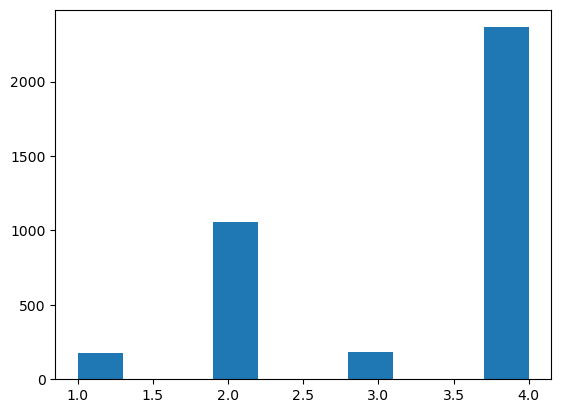

In [186]:
plt.hist(DF5['prediction_pooled'])

In [187]:
def prediction_results(df, x):
    precision1= (df[x]==1).sum()/((df[x]==1).sum() + (df[x]==2).sum())
    precision2= (df[x]==4).sum()/((df[x]==4).sum() + (df[x]==3).sum())
    accuracy= ((df[x]==1).sum() + (df[x]==4).sum())/((df[x]==1).sum() + (df[x]==2).sum()+
                                                    (df[x]==4).sum() + (df[x]==3).sum()) 
    print('Precision 1: ', precision1)
    print('Precision 0: ', precision2)
    print('Overall Accuracy:', accuracy)

In [188]:
prediction_results(DF5, 'prediction_pooled')

Precision 1:  0.1423948220064725
Precision 0:  0.9274509803921569
Overall Accuracy: 0.6711568938193344


In [12]:

DF7= DF4[['Region_fips','times','county_fips', 'state_fips', 'year','disadoption']+
         varsd]
DF7= DF7[DF7['year']==2022]

for x in varsd:
    DF7[x].replace(0, 0.00001, inplace=True)
    DF7[x+'_diff']= ((DF7[x]- DF7[x].mean()))/DF7[x].std() #standardize with population of counties
DF7.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
sigma1= 1 #bmb.Prior('HalfCauchy', beta= 1)

priors={'Intercept': bmb.Prior("Normal", mu= 0, sigma= 1),    
    'women_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'individual_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
        }
model22 = bmb.Model("disadoption ~ 1 +\
            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+\
(insurance_acres_diff)+(subsidy_ratio_diff)+\
(edd_mean_diff)+(pcpdays_mean_diff)+(tavg_std_diff)+(pcp_mm_std_diff)+(tavg_z_diff) +(pcp_mm_z_diff)+\
(women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+\
(pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+\
(individual_diff)+(human_diff)+(regulate_diff)",
            DF7, priors= priors, family="bernoulli", dropna=True)
model22

Automatically removing 2/1955 rows from the dataset.


Formula: disadoption ~ 1 +            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+(insurance_acres_diff)+(subsidy_ratio_diff)+(edd_mean_diff)+(pcpdays_mean_diff)+(tavg_std_diff)+(pcp_mm_std_diff)+(tavg_z_diff) +(pcp_mm_z_diff)+(women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+(pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+(individual_diff)+(human_diff)+(regulate_diff)
Family name: Bernoulli
Link: logit
Observations: 1953
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 1)
    cons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    noncons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    state_prog_ope_diff ~ Laplace(mu: 0, b: 1)
    insurance_acres_diff ~ Laplace(mu: 0, b: 1)
    subsidy_ratio_diff ~ Laplace(mu: 0, b: 1)
    edd_mean_diff ~ Laplace(mu: 0, b: 1)
    pcpdays_mean_diff ~ Laplace(mu: 0, b: 1)
    tavg_std_diff ~ Laplace(mu: 0, b: 1)
    pcp_mm_std_diff ~ Laplace(mu: 0, b: 1)
    tavg_z_diff ~ Laplace(mu: 0, b: 

In [15]:
trace22 = model22.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

KeyboardInterrupt: 

In [233]:
az.summary(trace17)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.124,0.058,-1.234,-1.017,0.001,0.001,5022.0,3194.0,1.0
cons_prog_income_diff,-0.083,0.062,-0.197,0.036,0.001,0.001,4476.0,2631.0,1.0
noncons_prog_income_diff,0.091,0.063,-0.025,0.213,0.001,0.001,4140.0,2876.0,1.0
state_prog_ope_diff,-0.061,0.058,-0.158,0.057,0.001,0.001,4878.0,2898.0,1.0
insurance_acres_diff,-0.409,0.090,-0.571,-0.240,0.001,0.001,3867.0,2547.0,1.0
subsidy_ratio_diff,0.083,0.070,-0.051,0.207,0.001,0.001,4278.0,3360.0,1.0
edd_mean_diff,0.194,0.100,0.012,0.381,0.002,0.001,2900.0,3007.0,1.0
pcpdays_mean_diff,-0.044,0.097,-0.233,0.129,0.002,0.001,2866.0,2697.0,1.0
tavg_std_diff,-0.182,0.074,-0.320,-0.039,0.001,0.001,3519.0,2863.0,1.0
pcp_mm_std_diff,-0.033,0.074,-0.172,0.105,0.001,0.001,3792.0,3217.0,1.0


In [16]:
priorsr={'1|Region_fips': bmb.Prior("Normal", mu= 0, sigma= 1),    
    'women_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'individual_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1)
        }

modelr22 = bmb.Model("disadoption ~ 0+ (1|Region_fips)+\
            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+\
            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+\
            (subsidy_ratio_diff|Region_fips)+\
            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+\
            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+\
            (tavg_z_diff|Region_fips) +(pcp_mm_z_diff|Region_fips)+\
            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+\
            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+(entropy_diff|Region_fips)+\
            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)",
            DF7, priors= priorsr, family="bernoulli", dropna=True)
modelr22

Automatically removing 2/1955 rows from the dataset.


Formula: disadoption ~ 0+ (1|Region_fips)+            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+            (subsidy_ratio_diff|Region_fips)+            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+            (tavg_z_diff|Region_fips) +(pcp_mm_z_diff|Region_fips)+            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+(entropy_diff|Region_fips)+            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)
Family name: Bernoulli
Link: logit
Observations: 1953
Priors:
  Group-level effects
    1|Region_fips ~ Normal(mu: 0, sigma: 1)
    cons_prog_income_diff|Region_fips ~ Laplace(mu: 0, b: 1)
    noncons_prog_income_diff|Reg

In [17]:
tracer22 = modelr22.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Modeling the probability that disadoption==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [regulate_diff|Region_fips, human_diff|Region_fips, individual_diff|Region_fips, entropy_diff|Region_fips, irrigated_harvcrop_ope_diff|Region_fips, pasture_cropland_diff|Region_fips, org_ope_diff|Region_fips, labor_expense_diff|Region_fips, women_acres_diff|Region_fips, pcp_mm_z_diff|Region_fips, tavg_z_diff|Region_fips, pcp_mm_std_diff|Region_fips, tavg_std_diff|Region_fips, pcpdays_mean_diff|Region_fips, edd_mean_diff|Region_fips, subsidy_ratio_diff|Region_fips, insurance_acres_diff|Region_fips, state_prog_ope_diff|Region_fips, noncons_prog_income_diff|Region_fips, cons_prog_income_diff|Region_fips, 1|Region_fips]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3709 seconds.


In [18]:
df1=dfsummary(tracer22)

In [20]:
df1[df1['region']=='2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[2],-0.782,0.462,-1.592,0.152,0.009,0.006,2584.0,2771.0,1.0,1|Region_fips[2],2
cons_prog_income_diff|Region_fips[2],0.139,0.370,-0.561,0.853,0.005,0.006,4568.0,2854.0,1.0,cons_prog_income_diff|Region_fips[2],2
noncons_prog_income_diff|Region_fips[2],-0.083,0.119,-0.300,0.148,0.002,0.002,4273.0,2956.0,1.0,noncons_prog_income_diff|Region_fips[2],2
state_prog_ope_diff|Region_fips[2],0.482,0.235,0.030,0.906,0.004,0.003,3976.0,2555.0,1.0,state_prog_ope_diff|Region_fips[2],2
insurance_acres_diff|Region_fips[2],0.031,0.233,-0.384,0.496,0.003,0.003,4648.0,3067.0,1.0,insurance_acres_diff|Region_fips[2],2
subsidy_ratio_diff|Region_fips[2],-0.005,0.175,-0.332,0.337,0.003,0.003,4796.0,2706.0,1.0,subsidy_ratio_diff|Region_fips[2],2
edd_mean_diff|Region_fips[2],-0.288,0.369,-1.010,0.361,0.007,0.005,3142.0,3010.0,1.0,edd_mean_diff|Region_fips[2],2
pcpdays_mean_diff|Region_fips[2],-0.493,0.353,-1.139,0.148,0.007,0.005,2800.0,3088.0,1.0,pcpdays_mean_diff|Region_fips[2],2
tavg_std_diff|Region_fips[2],0.026,0.139,-0.240,0.279,0.002,0.002,4056.0,2690.0,1.0,tavg_std_diff|Region_fips[2],2
pcp_mm_std_diff|Region_fips[2],-0.129,0.189,-0.499,0.222,0.003,0.003,4769.0,2966.0,1.0,pcp_mm_std_diff|Region_fips[2],2


In [21]:
df1[df1['region']=='4']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[4],-0.287,0.287,-0.841,0.235,0.006,0.004,2645.0,2722.0,1.0,1|Region_fips[4],4
cons_prog_income_diff|Region_fips[4],-0.060,0.078,-0.214,0.080,0.001,0.001,5043.0,3219.0,1.0,cons_prog_income_diff|Region_fips[4],4
noncons_prog_income_diff|Region_fips[4],-0.206,0.183,-0.561,0.121,0.003,0.002,4447.0,2996.0,1.0,noncons_prog_income_diff|Region_fips[4],4
state_prog_ope_diff|Region_fips[4],0.041,0.138,-0.208,0.314,0.002,0.002,6324.0,2904.0,1.0,state_prog_ope_diff|Region_fips[4],4
insurance_acres_diff|Region_fips[4],-0.307,0.205,-0.690,0.063,0.004,0.003,3119.0,3363.0,1.0,insurance_acres_diff|Region_fips[4],4
subsidy_ratio_diff|Region_fips[4],0.209,0.181,-0.144,0.532,0.003,0.002,4436.0,3012.0,1.0,subsidy_ratio_diff|Region_fips[4],4
edd_mean_diff|Region_fips[4],0.464,0.376,-0.205,1.179,0.007,0.005,2733.0,3024.0,1.0,edd_mean_diff|Region_fips[4],4
pcpdays_mean_diff|Region_fips[4],-0.606,0.345,-1.236,0.024,0.007,0.005,2311.0,2559.0,1.0,pcpdays_mean_diff|Region_fips[4],4
tavg_std_diff|Region_fips[4],0.036,0.165,-0.260,0.366,0.003,0.003,4267.0,2714.0,1.0,tavg_std_diff|Region_fips[4],4
pcp_mm_std_diff|Region_fips[4],-0.036,0.136,-0.291,0.215,0.002,0.002,4300.0,3098.0,1.0,pcp_mm_std_diff|Region_fips[4],4


In [22]:
df1[df1['region']=='5']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[5],0.063,0.308,-0.525,0.622,0.006,0.005,2731.0,2658.0,1.0,1|Region_fips[5],5
cons_prog_income_diff|Region_fips[5],-0.080,0.123,-0.308,0.145,0.002,0.002,4863.0,3063.0,1.0,cons_prog_income_diff|Region_fips[5],5
noncons_prog_income_diff|Region_fips[5],-0.042,0.103,-0.237,0.153,0.001,0.001,4860.0,3110.0,1.0,noncons_prog_income_diff|Region_fips[5],5
state_prog_ope_diff|Region_fips[5],-0.065,0.079,-0.219,0.074,0.001,0.001,4472.0,3099.0,1.0,state_prog_ope_diff|Region_fips[5],5
insurance_acres_diff|Region_fips[5],0.232,0.162,-0.064,0.539,0.003,0.002,3241.0,2942.0,1.0,insurance_acres_diff|Region_fips[5],5
subsidy_ratio_diff|Region_fips[5],0.040,0.113,-0.187,0.238,0.002,0.002,4998.0,2773.0,1.0,subsidy_ratio_diff|Region_fips[5],5
edd_mean_diff|Region_fips[5],0.225,0.222,-0.185,0.650,0.005,0.004,2160.0,2666.0,1.0,edd_mean_diff|Region_fips[5],5
pcpdays_mean_diff|Region_fips[5],-0.242,0.185,-0.593,0.090,0.003,0.002,3563.0,3359.0,1.0,pcpdays_mean_diff|Region_fips[5],5
tavg_std_diff|Region_fips[5],-0.048,0.174,-0.380,0.283,0.003,0.002,3408.0,3031.0,1.0,tavg_std_diff|Region_fips[5],5
pcp_mm_std_diff|Region_fips[5],0.109,0.105,-0.081,0.310,0.002,0.001,4206.0,3068.0,1.0,pcp_mm_std_diff|Region_fips[5],5


In [23]:
df1[df1['region']=='6']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[6],0.551,0.597,-0.559,1.666,0.011,0.008,3114.0,3275.0,1.0,1|Region_fips[6],6
cons_prog_income_diff|Region_fips[6],-0.121,0.413,-0.918,0.674,0.006,0.006,4409.0,2873.0,1.0,cons_prog_income_diff|Region_fips[6],6
noncons_prog_income_diff|Region_fips[6],0.314,0.445,-0.446,1.236,0.007,0.006,4162.0,2831.0,1.0,noncons_prog_income_diff|Region_fips[6],6
state_prog_ope_diff|Region_fips[6],0.216,0.250,-0.217,0.718,0.003,0.003,5235.0,3163.0,1.0,state_prog_ope_diff|Region_fips[6],6
insurance_acres_diff|Region_fips[6],-0.151,0.399,-0.882,0.608,0.007,0.006,3661.0,2639.0,1.0,insurance_acres_diff|Region_fips[6],6
subsidy_ratio_diff|Region_fips[6],0.104,0.273,-0.387,0.637,0.004,0.004,5083.0,3306.0,1.0,subsidy_ratio_diff|Region_fips[6],6
edd_mean_diff|Region_fips[6],-0.071,0.445,-1.014,0.715,0.007,0.007,3646.0,2985.0,1.0,edd_mean_diff|Region_fips[6],6
pcpdays_mean_diff|Region_fips[6],0.433,0.458,-0.398,1.329,0.007,0.006,3787.0,3171.0,1.0,pcpdays_mean_diff|Region_fips[6],6
tavg_std_diff|Region_fips[6],0.171,0.285,-0.390,0.694,0.004,0.004,4185.0,2915.0,1.0,tavg_std_diff|Region_fips[6],6
pcp_mm_std_diff|Region_fips[6],-0.156,0.233,-0.596,0.274,0.004,0.003,3638.0,2894.0,1.0,pcp_mm_std_diff|Region_fips[6],6


### Disadoption 2022

In [234]:
DF2= DF4[['Region_fips','times','county_fips', 'state_fips', 'year','disadoption']+
         varsd]
DF2= DF2[DF2['year']==2022]

for x in varsd:
    DF2[x].replace(0, 0.00001, inplace=True)
    DF2[x+'_diff']= ((DF2[x]- DF2[x].mean()))/DF2[x].std() #standardize with population of counties
DF2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [235]:

model22 = bmb.Model("disadoption ~ 1 +\
            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+\
(insurance_acres_diff)+(subsidy_ratio_diff)+\
(edd_mean_diff)+(pcpdays_mean_diff)+(tavg_std_diff)+(pcp_mm_std_diff)+(tavg_z_diff) +(pcp_mm_z_diff)+\
(women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+\
(pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+\
(individual_diff)+(human_diff)+(regulate_diff)",
            DF2, priors= priors, family="bernoulli", dropna=True)
model22

Automatically removing 2/1955 rows from the dataset.


Formula: disadoption ~ 1 +            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+(insurance_acres_diff)+(subsidy_ratio_diff)+(edd_mean_diff)+(pcpdays_mean_diff)+(tavg_std_diff)+(pcp_mm_std_diff)+(tavg_z_diff) +(pcp_mm_z_diff)+(women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+(pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+(individual_diff)+(human_diff)+(regulate_diff)
Family name: Bernoulli
Link: logit
Observations: 1953
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 1)
    cons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    noncons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    state_prog_ope_diff ~ Laplace(mu: 0, b: 1)
    insurance_acres_diff ~ Laplace(mu: 0, b: 1)
    subsidy_ratio_diff ~ Laplace(mu: 0, b: 1)
    edd_mean_diff ~ Laplace(mu: 0, b: 1)
    pcpdays_mean_diff ~ Laplace(mu: 0, b: 1)
    tavg_std_diff ~ Laplace(mu: 0, b: 1)
    pcp_mm_std_diff ~ Laplace(mu: 0, b: 1)
    tavg_z_diff ~ Laplace(mu: 0, b: 

In [236]:
trace22 = model22.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Modeling the probability that disadoption==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, regulate_diff, human_diff, individual_diff, entropy_diff, irrigated_harvcrop_ope_diff, pasture_cropland_diff, org_ope_diff, labor_expense_diff, women_acres_diff, pcp_mm_z_diff, tavg_z_diff, pcp_mm_std_diff, tavg_std_diff, pcpdays_mean_diff, edd_mean_diff, subsidy_ratio_diff, insurance_acres_diff, state_prog_ope_diff, noncons_prog_income_diff, cons_prog_income_diff]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.


In [237]:
az.summary(trace22)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.489,0.049,-0.578,-0.394,0.001,0.000,5464.0,2752.0,1.0
cons_prog_income_diff,-0.081,0.055,-0.188,0.017,0.001,0.001,5055.0,2949.0,1.0
noncons_prog_income_diff,-0.043,0.053,-0.142,0.060,0.001,0.001,5430.0,2655.0,1.0
state_prog_ope_diff,0.030,0.053,-0.075,0.125,0.001,0.001,5276.0,2963.0,1.0
insurance_acres_diff,-0.080,0.073,-0.211,0.059,0.001,0.001,4156.0,2713.0,1.0
subsidy_ratio_diff,0.005,0.061,-0.107,0.122,0.001,0.001,4527.0,2887.0,1.0
edd_mean_diff,-0.110,0.083,-0.263,0.046,0.001,0.001,3987.0,3011.0,1.0
pcpdays_mean_diff,0.115,0.087,-0.041,0.279,0.001,0.001,3822.0,2543.0,1.0
tavg_std_diff,0.055,0.063,-0.058,0.181,0.001,0.001,4817.0,2843.0,1.0
pcp_mm_std_diff,0.025,0.053,-0.073,0.125,0.001,0.001,5245.0,3140.0,1.0


## Multiregion

In [150]:
sigma1= 1 #bmb.Prior('HalfCauchy', beta= 1)

priorsr={'1|Region_fips': bmb.Prior("Normal", mu= 0, sigma= 1),    
    'women_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'individual_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'year_2022|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1)
        }

In [151]:
modelar = bmb.Model("disadoption ~ 0+ (1|Region_fips)+\
            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+\
            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+\
            (subsidy_ratio_diff|Region_fips)+\
            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+\
            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+\
            (tavg_z_diff|Region_fips) +(pcp_mm_z_diff|Region_fips)+\
            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+\
            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+(entropy_diff|Region_fips)+\
            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)+ (year_2022|Region_fips)",
            DF5, priors= priorsr, family="bernoulli", dropna=True)
modelar

Formula: disadoption ~ 0+ (1|Region_fips)+            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+            (subsidy_ratio_diff|Region_fips)+            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+            (tavg_z_diff|Region_fips) +(pcp_mm_z_diff|Region_fips)+            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+(entropy_diff|Region_fips)+            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)+ (year_2022|Region_fips)
Family name: Bernoulli
Link: logit
Observations: 3786
Priors:
  Group-level effects
    1|Region_fips ~ Normal(mu: 0, sigma: 1)
    cons_prog_income_diff|Region_fips ~ Laplace(mu: 0, b: 1)
    non

In [152]:
tracear = modelar.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Modeling the probability that disadoption==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [year_2022|Region_fips, regulate_diff|Region_fips, human_diff|Region_fips, individual_diff|Region_fips, entropy_diff|Region_fips, irrigated_harvcrop_ope_diff|Region_fips, pasture_cropland_diff|Region_fips, org_ope_diff|Region_fips, labor_expense_diff|Region_fips, women_acres_diff|Region_fips, pcp_mm_z_diff|Region_fips, tavg_z_diff|Region_fips, pcp_mm_std_diff|Region_fips, tavg_std_diff|Region_fips, pcpdays_mean_diff|Region_fips, edd_mean_diff|Region_fips, subsidy_ratio_diff|Region_fips, insurance_acres_diff|Region_fips, state_prog_ope_diff|Region_fips, noncons_prog_income_diff|Region_fips, cons_prog_income_diff|Region_fips, 1|Region_fips]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1792 seconds.


In [61]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index

    dfy['region']= dfy.variables.str[-2:-1]
    
    return dfy

In [153]:
df=dfsummary(tracear)

In [154]:
df[df['region']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[0],-0.349,0.814,-1.870,1.161,0.011,0.012,5088.0,3220.0,1.0,1|Region_fips[0],0
cons_prog_income_diff|Region_fips[0],-0.031,0.197,-0.408,0.341,0.003,0.003,5045.0,3030.0,1.0,cons_prog_income_diff|Region_fips[0],0
noncons_prog_income_diff|Region_fips[0],0.345,0.386,-0.379,1.055,0.005,0.005,5790.0,3007.0,1.0,noncons_prog_income_diff|Region_fips[0],0
state_prog_ope_diff|Region_fips[0],-0.129,0.193,-0.506,0.225,0.003,0.003,6014.0,3141.0,1.0,state_prog_ope_diff|Region_fips[0],0
insurance_acres_diff|Region_fips[0],0.095,0.462,-0.741,1.000,0.007,0.007,4441.0,2631.0,1.0,insurance_acres_diff|Region_fips[0],0
subsidy_ratio_diff|Region_fips[0],0.195,0.371,-0.495,0.908,0.005,0.005,4953.0,2598.0,1.0,subsidy_ratio_diff|Region_fips[0],0
edd_mean_diff|Region_fips[0],0.109,0.527,-0.887,1.143,0.008,0.008,4251.0,2760.0,1.0,edd_mean_diff|Region_fips[0],0
pcpdays_mean_diff|Region_fips[0],0.370,0.310,-0.230,0.928,0.005,0.004,4355.0,2596.0,1.0,pcpdays_mean_diff|Region_fips[0],0
tavg_std_diff|Region_fips[0],-0.487,0.498,-1.448,0.406,0.007,0.007,4793.0,2885.0,1.0,tavg_std_diff|Region_fips[0],0
pcp_mm_std_diff|Region_fips[0],0.060,0.326,-0.601,0.628,0.005,0.005,4625.0,2806.0,1.0,pcp_mm_std_diff|Region_fips[0],0


In [155]:
df[df['region']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[1],-0.177,0.843,-1.696,1.426,0.013,0.012,4428.0,3346.0,1.0,1|Region_fips[1],1
cons_prog_income_diff|Region_fips[1],0.017,0.191,-0.364,0.358,0.003,0.003,6248.0,2568.0,1.0,cons_prog_income_diff|Region_fips[1],1
noncons_prog_income_diff|Region_fips[1],-0.039,0.233,-0.508,0.383,0.003,0.004,5933.0,2662.0,1.0,noncons_prog_income_diff|Region_fips[1],1
state_prog_ope_diff|Region_fips[1],-0.866,0.965,-2.770,0.546,0.020,0.017,3655.0,2064.0,1.0,state_prog_ope_diff|Region_fips[1],1
insurance_acres_diff|Region_fips[1],0.811,0.509,-0.113,1.722,0.007,0.006,5073.0,3454.0,1.0,insurance_acres_diff|Region_fips[1],1
subsidy_ratio_diff|Region_fips[1],0.255,0.265,-0.224,0.769,0.004,0.004,4976.0,2591.0,1.0,subsidy_ratio_diff|Region_fips[1],1
edd_mean_diff|Region_fips[1],-0.218,0.291,-0.817,0.278,0.004,0.004,5098.0,3252.0,1.0,edd_mean_diff|Region_fips[1],1
pcpdays_mean_diff|Region_fips[1],0.605,0.684,-0.669,1.907,0.013,0.012,3108.0,2013.0,1.0,pcpdays_mean_diff|Region_fips[1],1
tavg_std_diff|Region_fips[1],-0.310,0.417,-1.077,0.472,0.006,0.006,4490.0,2923.0,1.0,tavg_std_diff|Region_fips[1],1
pcp_mm_std_diff|Region_fips[1],0.070,0.347,-0.612,0.702,0.006,0.005,3695.0,2592.0,1.0,pcp_mm_std_diff|Region_fips[1],1


In [156]:
df[df['region']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[2],-1.442,0.368,-2.069,-0.698,0.007,0.005,3134.0,3068.0,1.0,1|Region_fips[2],2
cons_prog_income_diff|Region_fips[2],0.009,0.150,-0.300,0.275,0.002,0.002,6009.0,3063.0,1.0,cons_prog_income_diff|Region_fips[2],2
noncons_prog_income_diff|Region_fips[2],-0.083,0.080,-0.234,0.067,0.001,0.001,6971.0,2776.0,1.0,noncons_prog_income_diff|Region_fips[2],2
state_prog_ope_diff|Region_fips[2],0.020,0.101,-0.163,0.215,0.001,0.002,7162.0,2439.0,1.0,state_prog_ope_diff|Region_fips[2],2
insurance_acres_diff|Region_fips[2],0.035,0.164,-0.284,0.329,0.002,0.003,6219.0,3118.0,1.0,insurance_acres_diff|Region_fips[2],2
subsidy_ratio_diff|Region_fips[2],0.058,0.112,-0.145,0.272,0.001,0.002,6578.0,3085.0,1.0,subsidy_ratio_diff|Region_fips[2],2
edd_mean_diff|Region_fips[2],0.656,0.246,0.200,1.112,0.004,0.003,3293.0,3081.0,1.0,edd_mean_diff|Region_fips[2],2
pcpdays_mean_diff|Region_fips[2],-0.182,0.228,-0.607,0.258,0.004,0.003,3918.0,2937.0,1.0,pcpdays_mean_diff|Region_fips[2],2
tavg_std_diff|Region_fips[2],-0.128,0.125,-0.363,0.101,0.002,0.001,6527.0,3162.0,1.0,tavg_std_diff|Region_fips[2],2
pcp_mm_std_diff|Region_fips[2],0.108,0.118,-0.098,0.340,0.001,0.002,6480.0,2922.0,1.0,pcp_mm_std_diff|Region_fips[2],2


In [157]:
df[df['region']== '3']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[3],-1.635,0.651,-2.884,-0.421,0.011,0.008,3430.0,3120.0,1.0,1|Region_fips[3],3
cons_prog_income_diff|Region_fips[3],0.269,0.198,-0.076,0.661,0.002,0.002,7240.0,3018.0,1.0,cons_prog_income_diff|Region_fips[3],3
noncons_prog_income_diff|Region_fips[3],-0.128,0.114,-0.349,0.080,0.001,0.001,6626.0,3046.0,1.0,noncons_prog_income_diff|Region_fips[3],3
state_prog_ope_diff|Region_fips[3],0.085,0.167,-0.225,0.400,0.002,0.003,7126.0,2781.0,1.0,state_prog_ope_diff|Region_fips[3],3
insurance_acres_diff|Region_fips[3],-0.093,0.221,-0.520,0.310,0.003,0.003,4683.0,2272.0,1.0,insurance_acres_diff|Region_fips[3],3
subsidy_ratio_diff|Region_fips[3],-0.167,0.267,-0.715,0.294,0.004,0.004,4927.0,3139.0,1.0,subsidy_ratio_diff|Region_fips[3],3
edd_mean_diff|Region_fips[3],0.469,0.364,-0.214,1.132,0.005,0.004,5189.0,3019.0,1.0,edd_mean_diff|Region_fips[3],3
pcpdays_mean_diff|Region_fips[3],-0.610,0.457,-1.433,0.246,0.008,0.006,3522.0,2901.0,1.0,pcpdays_mean_diff|Region_fips[3],3
tavg_std_diff|Region_fips[3],0.219,0.287,-0.311,0.766,0.004,0.004,5692.0,2961.0,1.0,tavg_std_diff|Region_fips[3],3
pcp_mm_std_diff|Region_fips[3],0.254,0.266,-0.233,0.751,0.004,0.003,5770.0,3195.0,1.0,pcp_mm_std_diff|Region_fips[3],3


In [158]:
df[df['region']== '4']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[4],-1.164,0.288,-1.724,-0.642,0.005,0.003,3677.0,2631.0,1.0,1|Region_fips[4],4
cons_prog_income_diff|Region_fips[4],-0.118,0.069,-0.253,0.008,0.001,0.001,5683.0,2772.0,1.0,cons_prog_income_diff|Region_fips[4],4
noncons_prog_income_diff|Region_fips[4],-0.336,0.123,-0.574,-0.115,0.002,0.001,6671.0,3116.0,1.0,noncons_prog_income_diff|Region_fips[4],4
state_prog_ope_diff|Region_fips[4],0.084,0.095,-0.093,0.261,0.001,0.001,7361.0,2694.0,1.0,state_prog_ope_diff|Region_fips[4],4
insurance_acres_diff|Region_fips[4],-0.133,0.153,-0.436,0.132,0.002,0.002,4051.0,2854.0,1.0,insurance_acres_diff|Region_fips[4],4
subsidy_ratio_diff|Region_fips[4],0.389,0.146,0.100,0.650,0.002,0.001,5095.0,3323.0,1.0,subsidy_ratio_diff|Region_fips[4],4
edd_mean_diff|Region_fips[4],-0.033,0.282,-0.561,0.487,0.005,0.004,3421.0,2682.0,1.0,edd_mean_diff|Region_fips[4],4
pcpdays_mean_diff|Region_fips[4],-0.170,0.221,-0.592,0.234,0.004,0.003,3664.0,2802.0,1.0,pcpdays_mean_diff|Region_fips[4],4
tavg_std_diff|Region_fips[4],-0.225,0.192,-0.618,0.109,0.003,0.002,5905.0,2902.0,1.0,tavg_std_diff|Region_fips[4],4
pcp_mm_std_diff|Region_fips[4],-0.239,0.121,-0.461,-0.020,0.002,0.001,5553.0,3335.0,1.0,pcp_mm_std_diff|Region_fips[4],4


In [159]:
df[df['region']== '5']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[5],-0.762,0.190,-1.113,-0.414,0.003,0.002,3646.0,3070.0,1.0,1|Region_fips[5],5
cons_prog_income_diff|Region_fips[5],-0.080,0.095,-0.253,0.104,0.001,0.001,7115.0,2853.0,1.0,cons_prog_income_diff|Region_fips[5],5
noncons_prog_income_diff|Region_fips[5],0.004,0.059,-0.103,0.120,0.001,0.001,5840.0,3377.0,1.0,noncons_prog_income_diff|Region_fips[5],5
state_prog_ope_diff|Region_fips[5],-0.057,0.049,-0.145,0.036,0.001,0.001,7711.0,3292.0,1.0,state_prog_ope_diff|Region_fips[5],5
insurance_acres_diff|Region_fips[5],0.104,0.116,-0.108,0.332,0.002,0.001,4968.0,3043.0,1.0,insurance_acres_diff|Region_fips[5],5
subsidy_ratio_diff|Region_fips[5],-0.039,0.083,-0.198,0.120,0.001,0.001,7459.0,2746.0,1.0,subsidy_ratio_diff|Region_fips[5],5
edd_mean_diff|Region_fips[5],0.245,0.152,-0.039,0.524,0.003,0.002,3413.0,3109.0,1.0,edd_mean_diff|Region_fips[5],5
pcpdays_mean_diff|Region_fips[5],-0.156,0.129,-0.385,0.102,0.002,0.002,3427.0,3336.0,1.0,pcpdays_mean_diff|Region_fips[5],5
tavg_std_diff|Region_fips[5],-0.306,0.172,-0.632,0.016,0.002,0.002,5392.0,3202.0,1.0,tavg_std_diff|Region_fips[5],5
pcp_mm_std_diff|Region_fips[5],0.149,0.085,-0.003,0.314,0.001,0.001,6757.0,3088.0,1.0,pcp_mm_std_diff|Region_fips[5],5


In [160]:
df[df['region']== '6']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[6],-0.517,0.419,-1.322,0.271,0.006,0.005,4749.0,2903.0,1.0,1|Region_fips[6],6
cons_prog_income_diff|Region_fips[6],-0.040,0.259,-0.549,0.434,0.003,0.005,6197.0,2867.0,1.0,cons_prog_income_diff|Region_fips[6],6
noncons_prog_income_diff|Region_fips[6],0.348,0.330,-0.267,0.971,0.004,0.004,5665.0,2968.0,1.0,noncons_prog_income_diff|Region_fips[6],6
state_prog_ope_diff|Region_fips[6],-0.058,0.169,-0.397,0.246,0.002,0.003,7097.0,2899.0,1.0,state_prog_ope_diff|Region_fips[6],6
insurance_acres_diff|Region_fips[6],-0.719,0.339,-1.346,-0.064,0.005,0.004,4479.0,3164.0,1.0,insurance_acres_diff|Region_fips[6],6
subsidy_ratio_diff|Region_fips[6],-0.059,0.228,-0.520,0.337,0.003,0.004,6714.0,3035.0,1.0,subsidy_ratio_diff|Region_fips[6],6
edd_mean_diff|Region_fips[6],0.076,0.359,-0.576,0.807,0.005,0.005,4524.0,2823.0,1.0,edd_mean_diff|Region_fips[6],6
pcpdays_mean_diff|Region_fips[6],0.021,0.325,-0.578,0.642,0.005,0.005,4900.0,2479.0,1.0,pcpdays_mean_diff|Region_fips[6],6
tavg_std_diff|Region_fips[6],0.228,0.310,-0.360,0.798,0.004,0.004,6220.0,3001.0,1.0,tavg_std_diff|Region_fips[6],6
pcp_mm_std_diff|Region_fips[6],0.043,0.222,-0.374,0.485,0.003,0.003,4949.0,2555.0,1.0,pcp_mm_std_diff|Region_fips[6],6


In [189]:

DF5['cons']=1 
varpost= ['1|Region_fips',#'cc_lag_diff|Region_fips','I(cc_lag_diff ** 2)|Region_fips',
            'cons_prog_income_diff|Region_fips','noncons_prog_income_diff|Region_fips',
            'state_prog_ope_diff|Region_fips','insurance_acres_diff|Region_fips',
            'subsidy_ratio_diff|Region_fips', #policies
            'edd_mean_diff|Region_fips', 'pcpdays_mean_diff|Region_fips',
            'tavg_std_diff|Region_fips','pcp_mm_std_diff|Region_fips', #weather
            'tavg_z_diff|Region_fips', 'pcp_mm_z_diff|Region_fips',
            'women_acres_diff|Region_fips', #demographics
            'labor_expense_diff|Region_fips', 'org_ope_diff|Region_fips', #farm management
            'pasture_cropland_diff|Region_fips','irrigated_harvcrop_ope_diff|Region_fips','entropy_diff|Region_fips',
            'individual_diff|Region_fips', 'human_diff|Region_fips', 'regulate_diff|Region_fips', #opinion
            'year_2022|Region_fips']

varsdf= ['cons',#'cc_lag_diff','I(cc_lag_diff ** 2)',
            'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff',#policies
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff', 'pcp_mm_z_diff',
            'women_acres_diff', #demographics
            'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'year_2022']

DF6_clean= DF5
DF6_clean.dropna(axis=0, how='any',subset=['disadoption','women_acres_diff', #demographics
            'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff', 
            'cons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff','noncons_prog_income_diff', #policies
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff', 'pcp_mm_z_diff',
            'year_2022'], inplace=True)

In [190]:
def significance(group):
    print('99% CI: ', az.hdi(tracear,var_names=varpost[0:12], hdi_prob = 0.99).sel(Region_fips_coord_group_factor=group))
    print('99% CI: ',az.hdi(tracear,var_names=varpost[12:], hdi_prob = 0.99).sel(Region_fips_coord_group_factor=group))
    print('90% CI: ',az.hdi(tracear,var_names=varpost[0:12], hdi_prob = 0.90).sel(Region_fips_coord_group_factor= group))
    print('90% CI: ',az.hdi(tracear,var_names=varpost[12:], hdi_prob = 0.90).sel(Region_fips_coord_group_factor= group))

In [191]:
significance('0')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '0'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -2.435 1.616
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.5506 0.4867
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.567 1.405
    state_prog_ope_diff|Region_fips       (hdi) float64 -0.6568 0.3191
    insurance_acres_diff|Region_fips      (hdi) float64 -1.093 1.393
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.709 1.243
    edd_mean_diff|Region_fips             (hdi) float64 -1.306 1.62
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.3747 1.226
    tavg_std_diff|Region_fips             (hdi) float64 -1.867 0.6735
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.777 0.9776
    tavg_z_diff|Region_fips               (hdi) float64 -1.386 0.5679
    pcp_m

In [192]:
significance('1')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '1'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -2.456 1.892
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.5041 0.5317
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.7265 0.5818
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.152 0.8278
    insurance_acres_diff|Region_fips      (hdi) float64 -0.3524 2.146
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.4003 0.9485
    edd_mean_diff|Region_fips             (hdi) float64 -1.002 0.4683
    pcpdays_mean_diff|Region_fips         (hdi) float64 -1.047 2.549
    tavg_std_diff|Region_fips             (hdi) float64 -1.482 0.6441
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.9105 0.952
    tavg_z_diff|Region_fips               (hdi) float64 -0.8615 0.9243
   

In [193]:
significance('2')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '2'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -2.409 -0.5393
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.4036 0.4055
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.2879 0.1229
    state_prog_ope_diff|Region_fips       (hdi) float64 -0.2793 0.2718
    insurance_acres_diff|Region_fips      (hdi) float64 -0.3868 0.4875
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.2354 0.3253
    edd_mean_diff|Region_fips             (hdi) float64 0.006501 1.263
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.7972 0.4039
    tavg_std_diff|Region_fips             (hdi) float64 -0.471 0.1842
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.1824 0.4142
    tavg_z_diff|Region_fips               (hdi) float64 -0.6518 0.

In [194]:
significance('3')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '3'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -3.272 0.04981
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.1818 0.7821
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.4311 0.1479
    state_prog_ope_diff|Region_fips       (hdi) float64 -0.3507 0.5243
    insurance_acres_diff|Region_fips      (hdi) float64 -0.6721 0.4851
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.88 0.5025
    edd_mean_diff|Region_fips             (hdi) float64 -0.4311 1.488
    pcpdays_mean_diff|Region_fips         (hdi) float64 -1.815 0.4635
    tavg_std_diff|Region_fips             (hdi) float64 -0.4937 0.9751
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.4115 0.9449
    tavg_z_diff|Region_fips               (hdi) float64 -1.159 0.4639

In [195]:
significance('4')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '4'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -1.923 -0.4396
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.3026 0.05588
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.6693 -0.04228
    state_prog_ope_diff|Region_fips       (hdi) float64 -0.1657 0.3205
    insurance_acres_diff|Region_fips      (hdi) float64 -0.5439 0.2426
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.003225 0.7392
    edd_mean_diff|Region_fips             (hdi) float64 -0.7828 0.7685
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.7576 0.3798
    tavg_std_diff|Region_fips             (hdi) float64 -0.7248 0.2349
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.552 0.06671
    tavg_z_diff|Region_fips               (hdi) float64 -0.1

In [196]:
significance('5')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '5'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -1.275 -0.3292
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.3286 0.1627
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.1525 0.148
    state_prog_ope_diff|Region_fips       (hdi) float64 -0.1839 0.06379
    insurance_acres_diff|Region_fips      (hdi) float64 -0.2018 0.4051
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.2573 0.1705
    edd_mean_diff|Region_fips             (hdi) float64 -0.1212 0.6736
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.4928 0.1569
    tavg_std_diff|Region_fips             (hdi) float64 -0.7482 0.1128
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.05851 0.3724
    tavg_z_diff|Region_fips               (hdi) float64 -0.3067 

In [197]:
significance('6')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '6'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -1.562 0.576
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.7412 0.6458
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.5158 1.219
    state_prog_ope_diff|Region_fips       (hdi) float64 -0.5225 0.3916
    insurance_acres_diff|Region_fips      (hdi) float64 -1.56 0.09973
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.694 0.5611
    edd_mean_diff|Region_fips             (hdi) float64 -0.8233 1.081
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.8766 0.832
    tavg_std_diff|Region_fips             (hdi) float64 -0.5037 1.098
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.5251 0.6375
    tavg_z_diff|Region_fips               (hdi) float64 -0.6534 0.5041
  

In [198]:
h= 0.0001
dfame2= ame.ame_stratified(DF6_clean, tracear, varsdf, varpost, h, 'Region_fips', 7, [0,1,2,3,4,5,6])

In [199]:
dfame2[:22]

,AME,std,CI25,CI97,Region_fips
cons,0.413605,1.114998e-16,0.413605,0.413605,0
cons_prog_income_diff,-0.006048,1.600408e-03,-0.007663,-0.002180,0
noncons_prog_income_diff,0.068030,1.800279e-02,0.024526,0.086203,0
state_prog_ope_diff,-0.025365,6.712337e-03,-0.032141,-0.009144,0
insurance_acres_diff,0.018793,4.973376e-03,0.006775,0.023814,0
subsidy_ratio_diff,0.038476,1.018210e-02,0.013871,0.048755,0
edd_mean_diff,0.021570,5.708143e-03,0.007776,0.027332,0
pcpdays_mean_diff,0.073049,1.933099e-02,0.026335,0.092563,0
tavg_std_diff,-0.095984,2.540092e-02,-0.121626,-0.034605,0
pcp_mm_std_diff,0.011785,3.118699e-03,0.004249,0.014933,0


In [200]:
dfame2[22:44]

,AME,std,CI25,CI97,Region_fips
cons,0.455748,1.672436e-16,0.455748,0.455748,1
cons_prog_income_diff,0.003303,1.014612e-03,0.000769,0.004301,1
noncons_prog_income_diff,-0.007531,2.313577e-03,-0.009807,-0.001753,1
state_prog_ope_diff,-0.166139,5.104236e-02,-0.216371,-0.038673,1
insurance_acres_diff,0.155630,4.781188e-02,0.036229,0.202681,1
subsidy_ratio_diff,0.048946,1.503708e-02,0.011394,0.063744,1
edd_mean_diff,-0.041931,1.288225e-02,-0.054609,-0.009761,1
pcpdays_mean_diff,0.116028,3.564580e-02,0.027010,0.151107,1
tavg_std_diff,-0.059575,1.830269e-02,-0.077586,-0.013868,1
pcp_mm_std_diff,0.013404,4.118101e-03,0.003120,0.017457,1


In [201]:
dfame2[44:66]

,AME,std,CI25,CI97,Region_fips
cons,0.191282,2.778080e-17,0.191282,0.191282,2
cons_prog_income_diff,0.002066,2.966200e-04,0.001309,0.002308,2
noncons_prog_income_diff,-0.018546,2.663200e-03,-0.020719,-0.011753,2
state_prog_ope_diff,0.004551,6.535425e-04,0.002884,0.005084,2
insurance_acres_diff,0.007941,1.140393e-03,0.005033,0.008872,2
subsidy_ratio_diff,0.012909,1.853781e-03,0.008181,0.014422,2
edd_mean_diff,0.146669,2.106143e-02,0.092950,0.163857,2
pcpdays_mean_diff,-0.040612,5.832086e-03,-0.045372,-0.025737,2
tavg_std_diff,-0.028651,4.114361e-03,-0.032009,-0.018157,2
pcp_mm_std_diff,0.024230,3.479483e-03,0.015355,0.027070,2


In [202]:
dfame2[66:88]

,AME,std,CI25,CI97,Region_fips
cons,0.163190,2.779266e-17,0.163190,0.163190,3
cons_prog_income_diff,0.044830,1.715156e-02,0.011743,0.067316,3
noncons_prog_income_diff,-0.021310,8.153152e-03,-0.031999,-0.005582,3
state_prog_ope_diff,0.014126,5.404414e-03,0.003700,0.021211,3
insurance_acres_diff,-0.015410,5.895871e-03,-0.023140,-0.004036,3
subsidy_ratio_diff,-0.027714,1.060328e-02,-0.041615,-0.007259,3
edd_mean_diff,0.078006,2.984433e-02,0.020433,0.117132,3
pcpdays_mean_diff,-0.101457,3.881767e-02,-0.152349,-0.026575,3
tavg_std_diff,0.036442,1.394255e-02,0.009546,0.054721,3
pcp_mm_std_diff,0.042312,1.618827e-02,0.011083,0.063535,3


In [203]:
dfame2[88:110]

,AME,std,CI25,CI97,Region_fips
cons,0.237963,0.000000,0.237963,0.237963,4
cons_prog_income_diff,-0.019184,0.006533,-0.029364,-0.008100,4
noncons_prog_income_diff,-0.054671,0.018619,-0.083682,-0.023084,4
state_prog_ope_diff,0.013659,0.004651,0.005767,0.020906,4
insurance_acres_diff,-0.021568,0.007345,-0.033013,-0.009107,4
subsidy_ratio_diff,0.063137,0.021501,0.026659,0.096638,4
edd_mean_diff,-0.005328,0.001815,-0.008155,-0.002250,4
pcpdays_mean_diff,-0.027684,0.009428,-0.042375,-0.011689,4
tavg_std_diff,-0.036602,0.012465,-0.056024,-0.015454,4
pcp_mm_std_diff,-0.038903,0.013249,-0.059546,-0.016426,4


In [204]:
dfame2[110:132]

,AME,std,CI25,CI97,Region_fips
cons,0.318243,5.553809e-17,0.318243,0.318243,5
cons_prog_income_diff,-0.018185,1.995554e-03,-0.020011,-0.013330,5
noncons_prog_income_diff,0.000868,9.528240e-05,0.000636,0.000955,5
state_prog_ope_diff,-0.012926,1.418408e-03,-0.014224,-0.009475,5
insurance_acres_diff,0.023581,2.587643e-03,0.017285,0.025949,5
subsidy_ratio_diff,-0.008798,9.654339e-04,-0.009681,-0.006449,5
edd_mean_diff,0.055679,6.109833e-03,0.040814,0.061270,5
pcpdays_mean_diff,-0.035453,3.890489e-03,-0.039013,-0.025987,5
tavg_std_diff,-0.069529,7.629880e-03,-0.076510,-0.050965,5
pcp_mm_std_diff,0.033748,3.703243e-03,0.024737,0.037136,5


In [205]:
dfame2[132:]

,AME,std,CI25,CI97,Region_fips
cons,0.373518,5.559178e-17,0.373518,0.373518,6
cons_prog_income_diff,-0.007714,1.939389e-03,-0.010069,-0.004210,6
noncons_prog_income_diff,0.066525,1.672564e-02,0.036311,0.086842,6
state_prog_ope_diff,-0.011122,2.796277e-03,-0.014518,-0.006070,6
insurance_acres_diff,-0.137428,3.455350e-02,-0.179401,-0.075010,6
subsidy_ratio_diff,-0.011355,2.854946e-03,-0.014823,-0.006198,6
edd_mean_diff,0.014601,3.671041e-03,0.007970,0.019060,6
pcpdays_mean_diff,0.003944,9.915673e-04,0.002153,0.005148,6
tavg_std_diff,0.043683,1.098265e-02,0.023843,0.057023,6
pcp_mm_std_diff,0.008237,2.070877e-03,0.004496,0.010752,6


In [206]:
varpost= ['1|Region_fips',#'cc_lag_diff|Region_fips','I(cc_lag_diff ** 2)|Region_fips',
            'cons_prog_income_diff|Region_fips','noncons_prog_income_diff|Region_fips',
            'state_prog_ope_diff|Region_fips','insurance_acres_diff|Region_fips',
            'subsidy_ratio_diff|Region_fips', #policies
            'edd_mean_diff|Region_fips', 'pcpdays_mean_diff|Region_fips',
            'tavg_std_diff|Region_fips','pcp_mm_std_diff|Region_fips', #weather
            'tavg_z_diff|Region_fips', 'pcp_mm_z_diff|Region_fips',
            'women_acres_diff|Region_fips', #demographics
            'labor_expense_diff|Region_fips', 'org_ope_diff|Region_fips', #farm management
            'pasture_cropland_diff|Region_fips','irrigated_harvcrop_ope_diff|Region_fips','entropy_diff|Region_fips',
            'individual_diff|Region_fips', 'human_diff|Region_fips', 'regulate_diff|Region_fips', #opinion
            'year_2022|Region_fips']

varsdf= ['cons',#'cc_lag_diff','I(cc_lag_diff ** 2)',
            'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff',#policies
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff', 'pcp_mm_z_diff',
            'women_acres_diff', #demographics
            'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'year_2022']

In [207]:
for r in list(range(7)):
    for x,i in zip(varsdf, list(range(len(varpost)))):
        label= 'beta_'+x
        DF5.loc[DF5['Region_fips']== r, label] = df[df['region']==str(r)].iloc[i,0]
        
for x,i in zip(varsdf, list(range(len(varpost)))):        
    DF5['beta_'+x]= DF5['beta_'+x] * DF5[x]
    
A= ['beta_cons', #'beta_cc_lag_diff', 'beta_I(cc_lag_diff ** 2)',
       'beta_cons_prog_income_diff', 'beta_noncons_prog_income_diff',
       'beta_state_prog_ope_diff', 'beta_insurance_acres_diff',
       'beta_subsidy_ratio_diff', 'beta_edd_mean_diff', 'beta_pcpdays_mean_diff',
       'beta_tavg_std_diff', 'beta_pcp_mm_std_diff', 'beta_tavg_z_diff', 'beta_pcp_mm_z_diff',
       'beta_women_acres_diff',
       'beta_labor_expense_diff', 'beta_org_ope_diff',
       'beta_pasture_cropland_diff', 'beta_irrigated_harvcrop_ope_diff',
       'beta_entropy_diff', 'beta_individual_diff', 'beta_human_diff',
       'beta_regulate_diff', 'beta_year_2022']

DF5['likelihood']= 1/(1+ np.exp(-DF5[A].sum(axis=1)))
DF5['y_hat'] = np.where(DF5['likelihood']>0.5, 1, 0)

condlist= [(DF5['y_hat']==1) & (DF5['disadoption']==1), 
           ((DF5['y_hat']==0) & (DF5['disadoption']==1)), 
          ((DF5['y_hat']==1) & (DF5['disadoption']==0)), 
           ((DF5['y_hat']==0) & (DF5['disadoption']==0))]
choicelist=[1,2,3,4]
DF5['prediction'] = np.select(condlist, choicelist, np.nan)

(array([ 335.,    0.,    0.,  901.,    0.,    0.,  252.,    0.,    0.,
        2298.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

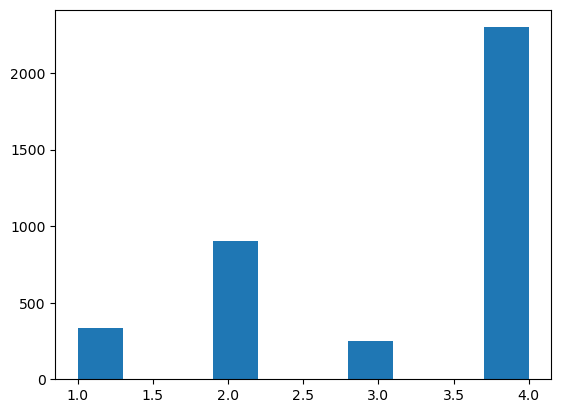

In [208]:
plt.hist(DF5['prediction'])

In [209]:
prediction_results(DF5, 'prediction')

Precision 1:  0.27103559870550165
Precision 0:  0.9011764705882352
Overall Accuracy: 0.6954569466455361
